In [1]:
import os
import sys
import time
from datetime import datetime
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from model_settings import ms
import matplotlib.pyplot as plt
os.chdir(os.path.abspath(str(Path())))
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
notebook_dir = str(Path().resolve())
sys.path.append(os.path.join(notebook_dir,'historical_data','historical_generation'))
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}\n")


pricing settings:
Actual/365 (Fixed) day counter
New York stock exchange calendar
compounding: continuous
frequency: annual


##################
# training start #
##################

Fri Oct 11 12:50:50 2024



# Loading data


importing dataset(s)...



loading: 100%|█████████████████████████████████████████████████████████████████████| 1246/1246 [00:20<00:00, 59.43it/s]



preparing data...


         spot_price  strike_price       barrier  days_to_maturity  \
count 6771002.00000 6771002.00000 6771002.00000     6771002.00000   
mean     1233.34316    1232.60081    1233.43707         328.99475   
min       676.03000     608.42700     338.01500          60.00000   
25%       920.98000     941.34067     859.11847          90.00000   
50%      1329.75000    1313.52318    1183.13120         360.00000   
75%      1466.35000    1448.69559    1552.19655         540.00000   
max      1565.18000    1721.69800    2347.77000         720.00000   
std       263.75498     273.44447     470.77454         241.54975   

       barrier_price        rebate  dividend_rate  risk_free_rate  \
count  6771002.00000 6771002.00000  6771002.00000   6771002.00000   
mean        53.40253       0.00000        0.02324         0.04000   
min          0.00000       0.00000        0.01780         0.04000   
25%          3.57276       0.00000        0.01915         0.04000   
50%         

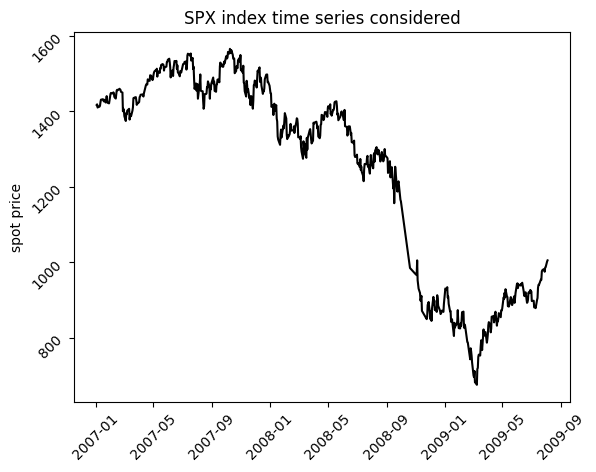

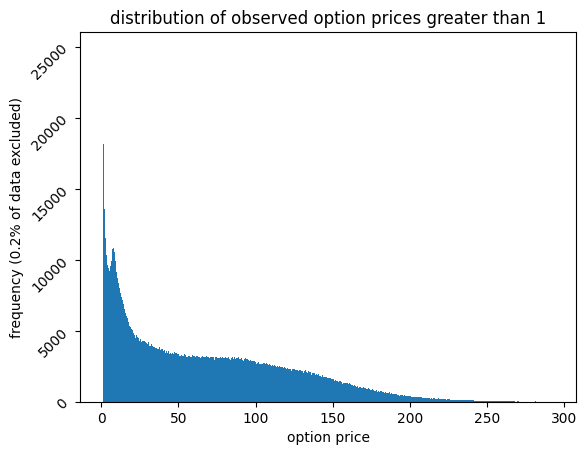

<Figure size 640x480 with 0 Axes>

In [2]:
from HDF_collection import contracts
dataset = contracts.copy()

# Data Cleaning

## Checking data

In [ ]:
check = dataset.copy().set_index('calculation_date').sort_index(ascending=True)
check = check[
    (check.index>datetime(2008,9,29))
    &
    (check.index<datetime(2008,11,5))
]
check
plt.figure()
plt.plot(check['spot_price'])
plt.xticks(rotation=45)
plt.title('possible anomanly in time series')
plt.show()
plt.clf()

## Filtering data

In [ ]:
dataset = dataset.set_index('calculation_date')
dataset = dataset[
    ~(
    (dataset.index>datetime(2008,9,30))
        &
    (dataset.index<datetime(2008,11,4))
    )
]
plt.figure()
plt.plot(dataset['spot_price'].copy().drop_duplicates(),color='black')
plt.xticks(rotation=45)
plt.title('exclusion of anomaly')
plt.show()
plt.clf()
dataset = dataset.reset_index()
print(dataset.describe().iloc[1:,:])
print(f"\ncount {dataset.shape[0]}")

In [ ]:
from convsklearn import barrier_trainer
bt = barrier_trainer

## Splitting data

In [ ]:
"""
train/test split
"""
unique_dates = dataset['calculation_date'].sort_values(
    ascending=True).unique().tolist()
filter_date = unique_dates[int(0.85*len(unique_dates))]

train_data = dataset[
    (
      # (dataset['calculation_date']>=datetime(2007,1,1))
      #  &
      (dataset['calculation_date']<=filter_date)
    )
].copy()

test_data = dataset[
    (
        (dataset['calculation_date']>filter_date)
        # &
        # (dataset['calculation_date']<=datetime(2012,12,31))
    )
].copy()

# Preprocessing

In [ ]:
train_X, train_y, test_X, test_y = bt.get_train_test_arrays(
    train_data, test_data)
preprocessor = bt.preprocess()
train_startdate = train_data.describe()['calculation_date']['min'].strftime('%A, %Y-%m-%d')
train_enddate = train_data.describe()['calculation_date']['max'].strftime('%A, %Y-%m-%d')
print(f"\ntraining from\n{train_startdate}\nto\n{train_enddate}\n")

In [ ]:
print(f"\n{train_data.dtypes}")
test_train_ratio = test_data.describe(
    ).iloc[0,0]/train_data.describe().iloc[0,0]

print(f"\ntrain/test: {int(round((1-test_train_ratio)*100,0))}/"
      +str(int(round(test_train_ratio*100,0))))

# Training

In [ ]:
model_fit, runtime, specs = bt.run_dnn(preprocessor,train_X,train_y)
train_end = time.time()
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")


training...

Deep Neural Network
hidden layers sizes: (13, 13, 13)
learning rate: adaptive
activation: relu
solver: sgd
alpha: 0.0001


# Testing

In [ ]:
test_data.describe()

In [ ]:
insample, outsample, errors = bt.test_prediction_accuracy(
        model_fit,
        test_data,
        train_data
        )

# Saving

In [ ]:
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H-%M-%S"))
file_tag = str(train_end_tag + " " + specs[0] )
os.chdir(os.path.join(notebook_dir,'trained_models'))
files_dir = os.path.join(
    notebook_dir,'trained_models','trained_models',
    file_tag)

if Path(files_dir).exists():
    pass
else:
    os.mkdir(files_dir)

file_dir = os.path.join(files_dir,file_tag)

S = np.sort(train_data['spot_price'].unique())
K = np.sort(train_data['strike_price'].unique())
T = np.sort(train_data['days_to_maturity'].unique())
W = np.sort(train_data['w'].unique())
n_calls = train_data[train_data['w']=='call'].shape[0]
n_puts = train_data[train_data['w']=='put'].shape[0]
insample.to_csv(f"{file_dir} insample.csv")
outsample.to_csv(f"{file_dir} outsample.csv")
joblib.dump(model_fit,str(f"{file_dir}.pkl"))
pd.set_option("display.max_columns",None)

with open(f'{file_dir}.txt', 'w') as file:
    file.write(train_start_tag)
    file.write(f"\nspot(s):\n{S}")
    file.write(f"\n\nstrikes:\n{K}\n")
    file.write(f"\nmaturities:\n{T}\n")
    file.write(f"\ntypes:\n{W}\n")
    try:
        file.write(f"\n{train_data['barrier_type_name'].unique()}")
    except Exception:
        pass
    file.write("")
    file.write(f"\nnumber of calls, puts:\n{n_calls},{n_puts}\n")
    file.write(f"\ntotal prices:\n{train_data.shape[0]}\n")
    for spec in specs:
        file.write(f"{spec}\n")
    file.write("#"*17+"\n# training data #\n"+"#"*17+
          f"\n{train_data.describe()}\n")
    file.write("#"*13+"\n# test data #\n"+"#"*13+
          f"\n{test_data.describe()}\n")
    file.write(f"\n{dataset.dtypes}")
    file.write(
        f"\nin sample results:"
        f"\n     RMSE: {errors['insample_RMSE']}"
        f"\n     MAE: {errors['insample_MAE']}\n"
        f"\nout of sample results:"
        f"\n     RMSE: {errors['outofsample_RMSE']}"
        f"\n     MAE: {errors['outofsample_MAE']}\n"
        )
    file.write("\nfeatures:\n")
    for feature in bt.feature_set:
        file.write(f"     {feature}\n")
    file.write(f"\ntarget: {bt.target_name}\n")
    file.write(f"\ncpu: {train_runtime}\n")
    file.write(datetime.fromtimestamp(train_end).strftime('%c'))